Notebook adaptado del curso “Diplomatura en Inteligencia Artificial y Ciencia de Datos” dictado por la ECyT-UNSAM en el marco del plan Argentina Programa 4.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.clear_session()

# Uso de AutoEncoders para detectar anomalías.

Una de las aplicacciones de los autoencoders es la **detección de anomalías / errores**; es decir, datos que no pertenecen a la misma distribución que el conjunto de entrenamiento.

Hay dos maneras, principalmente, de evaluar cuán lejos está un punto del conjunto del dataset de entrenamiento usando autoencoders:

1. comparar el error de reconstrucción
2. comparar la posición de la codificación en el espacio latente.

Vamos a retomar el dataset de las tarjetas de crédito para evaluar la capacidade los autoenconders para detectar las transacciones fraudulentas.

## Obtención de los datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train = pd.read_csv('/content/drive/MyDrive/AANuclear/Data/creditcard_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/AANuclear/Data/creditcard_test.csv')

Veamos rápidamente los datos.

In [4]:
X_train.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,20851,1.321432,-0.356293,0.300205,0.201982,-0.208365,0.743361,-0.656105,0.070828,-0.881980,...,-1.232635,-0.388459,-0.281173,-0.243962,-0.163223,-1.324377,0.537850,-0.189712,0.088370,0.026635
1,155337,-0.605459,0.917276,2.369555,-0.139944,0.140190,-0.259833,0.522574,-0.295835,1.562154,...,0.472211,0.036851,-0.287622,-0.399948,-0.306285,-0.112976,0.239806,-0.738243,-0.212029,-0.143259
2,111001,1.279970,-0.266108,-0.992069,-0.285321,1.883019,3.657542,-0.715670,0.900671,0.496412,...,0.559915,-0.003480,-0.142442,-0.316956,-0.123535,1.063070,0.742956,0.453687,-0.014068,0.004009
3,86746,-1.544809,-1.552024,1.691270,-2.704450,-0.754460,-1.160318,0.418050,-0.146795,-0.211499,...,-0.384878,0.321047,-0.118830,-0.358626,0.406065,0.396461,0.596016,-0.081761,-0.039167,0.099800
4,193607,-1.160451,-0.684065,1.339608,-2.474749,0.044282,1.807347,0.662735,0.499480,-1.291674,...,-0.224986,0.483143,0.014931,-0.349837,0.293706,-1.686113,0.339169,-0.429552,-0.013272,0.042696


In [5]:
X_test.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,202371,2.138046,0.090194,-2.449974,0.522469,0.578042,-1.794888,0.913447,-0.570769,0.142075,...,0.067419,-0.363305,0.239569,0.782559,-0.183510,-0.059540,0.634883,0.735714,-0.137668,-0.097352
1,204691,-0.248224,0.728713,-0.582032,-0.676084,1.339694,-0.418703,0.820419,0.002756,-0.252639,...,0.221051,0.006054,-0.313248,-0.729786,0.311922,0.181350,-0.334001,0.114217,0.125575,0.037668
2,256660,2.134145,-0.661134,-1.620203,-1.809978,-0.493491,-1.650889,0.049240,-0.394478,2.479669,...,1.286566,-0.301007,0.169722,0.935373,-0.103471,0.033117,0.550642,-0.551365,0.032345,-0.064503
3,87120,-1.247223,1.473491,2.358967,0.452132,-0.283562,-0.090984,0.754620,-0.489365,0.723121,...,0.446239,0.712766,-0.200742,0.041708,-0.244385,0.480266,0.249295,-0.496836,-0.302590,-0.436892
4,85534,1.052610,-0.161350,0.190391,1.259294,-0.172069,0.297286,-0.129089,0.266126,0.382070,...,0.045509,-0.214113,-0.068596,-0.209817,-0.129953,-0.345397,0.585089,-0.307521,0.012335,0.005977


In [6]:
print(X_train.shape)
print(X_test.shape)

(50000, 29)
(57355, 29)


Eliminamos la primera columna, que es el identificador de la transacción

In [7]:
X_train.drop(['Unnamed: 0',], axis=1, inplace=True)

In [8]:
# Para el test, guardamos la info para comparar
id_test = X_test['Unnamed: 0']
X_test.drop(['Unnamed: 0',], axis=1, inplace=True)

Recobremos, además, las etiquetas a partir de un archivo que tiene los índices de las transacciones fraudulentas.

In [9]:
# Ahora recobremos los valores reales
id_fraudes = np.loadtxt('/content/drive/MyDrive/AANuclear/Data/credit_fraud.txt')

t_test = id_test.isin(id_fraudes)

## Construcción del modelo

In [10]:
# tamano de la representación interna.
encoding_dim = 5  # 32 flotantes -> un factor de compresión de 24.5

#input placeholder
input_layer = keras.layers.Input(shape=(28,))

In [11]:
### Primero el encoder
#
encoded = keras.layers.Dense(16, activation='relu')(input_layer)
encoded = keras.layers.Dense(8, activation='relu')(encoded)
encoded = keras.layers.Dense(encoding_dim, activation='tanh')(encoded)

encoder = keras.models.Model(input_layer, outputs=encoded)

### Ahora el decoder
decoded = keras.layers.Dense(8, activation='relu')(encoded)
decoded = keras.layers.Dense(16, activation='relu')(decoded)
decoded = keras.layers.Dense(28, activation='linear')(decoded)

# Combinamos ambos modelos
autoencoder = keras.models.Model(input_layer, outputs=decoded)

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │           476 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

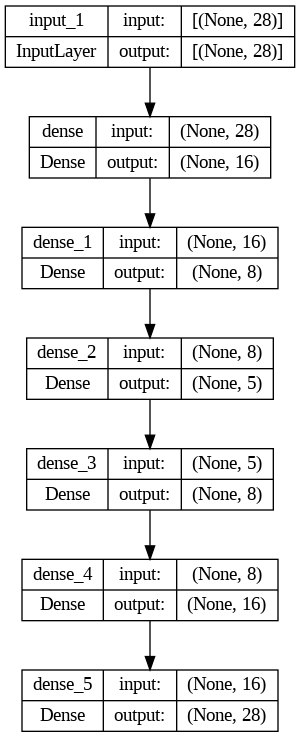

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes=True, rankdir='TD')

In [12]:
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

In [13]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history = autoencoder.fit(X_train, X_train,
                          epochs=1000,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping_cb],)
                        #   verbose=False)

Epoch 1/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0581 - mae: 0.6490 - val_loss: 0.9694 - val_mae: 0.6260
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9320 - mae: 0.6165 - val_loss: 0.8532 - val_mae: 0.5879
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8271 - mae: 0.5811 - val_loss: 0.7830 - val_mae: 0.5629
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7662 - mae: 0.5578 - val_loss: 0.7301 - val_mae: 0.5435
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7184 - mae: 0.5407 - val_loss: 0.6846 - val_mae: 0.5269
Epoch 6/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6636 - mae: 0.5256 - val_loss: 0.6472 - val_mae: 0.5152
Epoch 7/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6465 - mae: 0.5137 - val_loss: 0.6153 - val_mae: 0.5047
Epoch 8/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6270 - mae: 0.5044 - val_loss: 0.5909 - val_mae: 0.4963
Epoch 9/1000
157/157 ━━━━━━━━━━━━━━━━━━━

Text(0, 0.5, 'Pérdida')

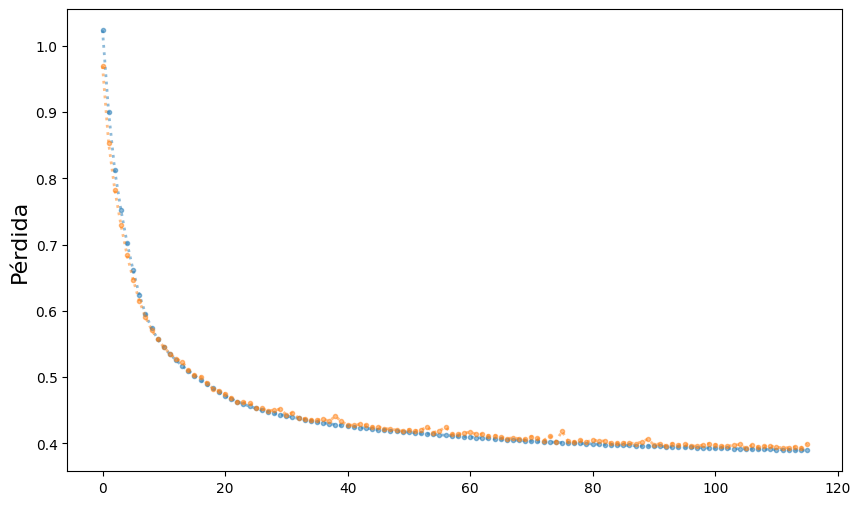

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

kw = {'marker': '.', 'lw': 2, 'alpha': 0.5}
ll0, = ax.plot(history.history['loss'], ls=':', color='C0', label='Train Loss', **kw)
ll1, = ax.plot(history.history['val_loss'], ls=':', color='C1', label='Validation Loss', **kw)

ax.set_ylabel('Pérdida', fontsize=16)

# ax.legend(handles=[l0, l1, ll0, ll1], loc='center', fontsize=14)
# plt.legend(loc=0)

Salvamos los modelos.

In [17]:
autoencoder.save('/content/drive/MyDrive/AANuclear/autoencoder_notebook10.keras')

In [18]:
encoder.save('/content/drive/MyDrive/AANuclear/encoder_notebook10.keras')

## Detección de anomalías

### Mirando los códigos

Calculamos los códigos del conjunto de entrenamiento y de testeo y vemos si tienen una distribución muy diferente.

La codificación se obtiene con el `encoder`, que habíamos separado, y que fue entrenado a la vez que el `autoencoder`. Necesitamos usar el método `predict`.

In [19]:
codes_train = encoder.predict(X_train)
print(codes_train.shape)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
(50000, 5)


Calculemos ahora los códigos del conjunto de testeo

In [20]:
codes_test = encoder.predict(X_test)
print(codes_test.shape)

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
(57355, 5)


Como se trata de vectores de dos dimensiones, podemos fácilmente graficarlos en el plano.

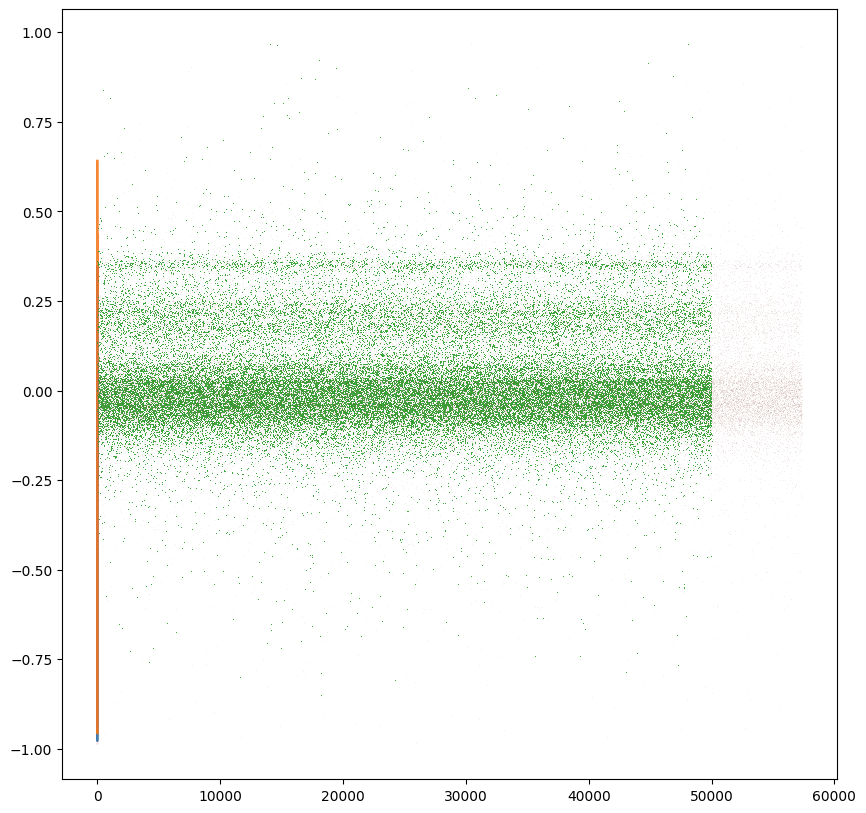

In [21]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)

# ax.hexbin(codes_train[:, 0], codes_train[:, 1], gridsize=40, cmap='gray_r')
ax.plot(*codes_train.T, ',', alpha=0.9)
ax.plot(*codes_test.T, ',', alpha=0.1)

A simple vista, no vemos de manera clara que haya puntos naranjas fuera de la distribución. Si los datos anómalos son muy poco numerosos, no esperamos que sea manera sea fácil detectar las transacciones fraudulentas.

In [22]:
# Cálculo la media de los códigos en entrenamiento
mean_codes = np.mean(codes_train, axis=0)

# Y las distancias a los códigos de test
mae_test = tf.keras.losses.mae(mean_codes, codes_test)

Ahora calculamos el límite de la distancia

In [23]:
# Check the prediction loss threshold for 2% of outliers
distance_threshold = np.percentile(mae_test, 98)
print(f'El umbral de distancia al centro de los codings es {distance_threshold:.2f}')

El umbral de distancia al centro de los codings es 0.27


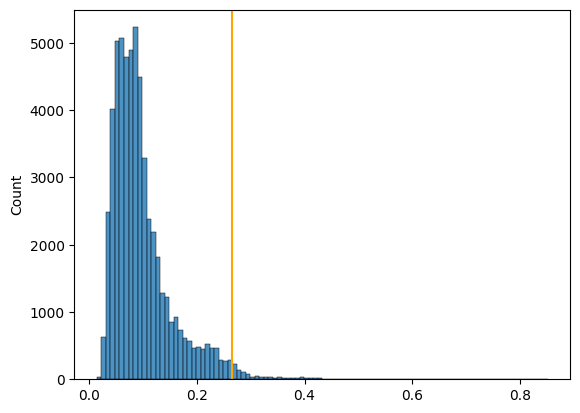

In [24]:
import seaborn as sns
sns.histplot(mae_test, bins=100, alpha=0.8)
plt.axvline(x=distance_threshold, color='orange')

In [25]:
y_test_dist = mae_test.numpy() >= distance_threshold

Ahora tenemos la predicción y la etiqueta verdadera. Podemos calcular la matriz de confusión

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(t_test, y_test_dist))
print(classification_report(t_test, y_test_dist))

[[55827  1036]
 [  380   112]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.99     56863
        True       0.10      0.23      0.14       492

    accuracy                           0.98     57355
   macro avg       0.55      0.60      0.56     57355
weighted avg       0.99      0.98      0.98     57355



Vemos que este approach no es muy bueno en este caso, y produce un F1 de menos de 10%.

### Mirando el error de reconstrucción

Otra opción es mirar el **error de reconstrucción**

In [27]:
prediction = autoencoder.predict(X_test)

prediction_loss = tf.keras.losses.mae(prediction, X_test)

# Check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'El umbral de pérdida elegido es {loss_threshold:.2f}')

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
El umbral de pérdida elegido es 0.99


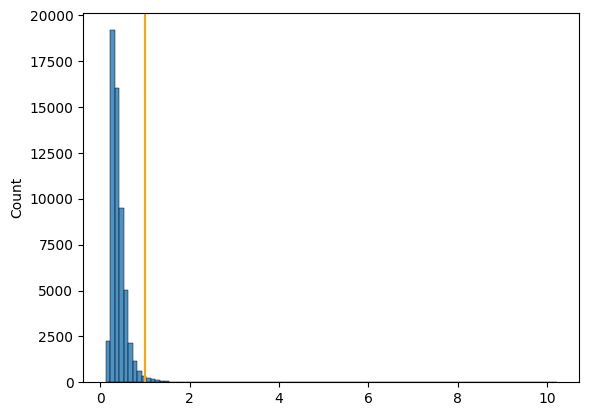

In [28]:
import seaborn as sns
sns.histplot(prediction_loss, bins=100, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')


Vamos a definir a todas las instancias que estén por arriba de 1.2 como outliers.

In [29]:
y_test = prediction_loss.numpy() >= loss_threshold

Ahora tenemos la predicción y la etiqueta verdadera. Podemos calcular la matriz de confusión

In [30]:
print(confusion_matrix(t_test, y_test))
print(classification_report(t_test, y_test))

[[56122   741]
 [   85   407]]
              precision    recall  f1-score   support

       False       1.00      0.99      0.99     56863
        True       0.35      0.83      0.50       492

    accuracy                           0.99     57355
   macro avg       0.68      0.91      0.74     57355
weighted avg       0.99      0.99      0.99     57355



In [31]:
2* (0.35 * 0.82 ) / (0.35 + 0.82)

0.4905982905982906

Y también podemos ver cómo cambian las métricas a medida que cambiamos el umbral de clasificación (recuerden que eso lo fijamos arriba a 1.2). Para eso, graficamos la curva ROC y calculamos el área bajo la curva.

Area bajo la curva (distancia): 0.80
Area bajo la curva (pérdida): 0.95


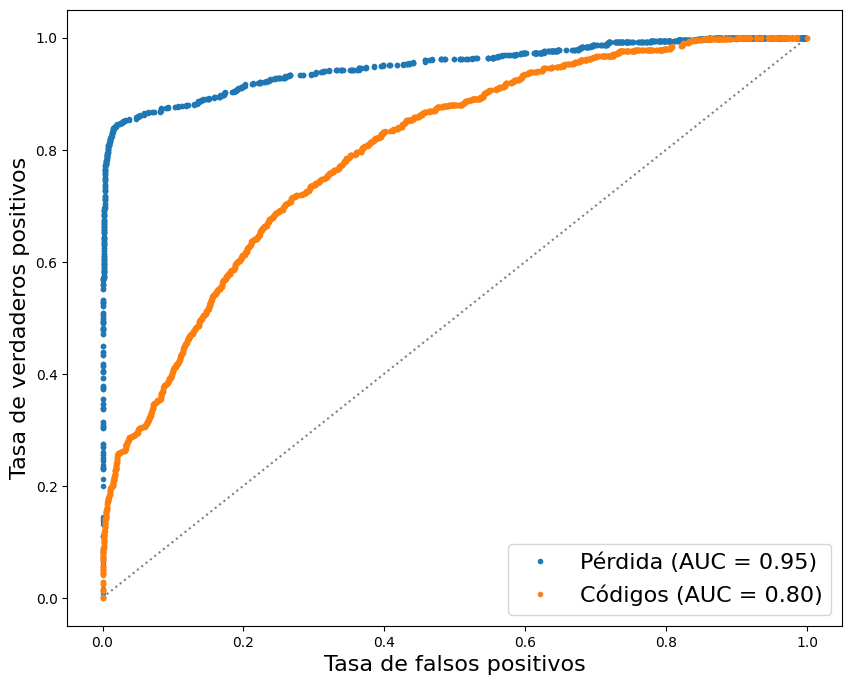

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_d, tpr_d, thr = roc_curve(t_test, mae_test)
auc_dist = roc_auc_score(t_test, mae_test)
print(f'Area bajo la curva (distancia): {auc_dist:.2f}')


fpr, tpr, thr = roc_curve(t_test, prediction_loss)
auc_loss = roc_auc_score(t_test, prediction_loss)
print(f'Area bajo la curva (pérdida): {auc_loss:.2f}')


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot curves
_ = ax.plot([0, 1], [0, 1], ls=':', color='0.5')
_ = ax.plot(fpr, tpr, '.', lw=5, label=f'Pérdida (AUC = {auc_loss:.2f})')
_ = ax.plot(fpr_d, tpr_d, '.', lw=5, label=f'Códigos (AUC = {auc_dist:.2f})')

# Labels
_ = ax.set_xlabel('Tasa de falsos positivos', fontsize=16)
_ = ax.set_ylabel('Tasa de verdaderos positivos', fontsize=16)

_ = ax.legend(loc=0, fontsize=16)

Vemos que el autoencoder tiene capacidad de separar correctamente las transacciones fraudulentas cuando usamos como métrica el error de reconstrucción. Aunque la precisión del método no sea tan buena.

En el ejercicio de esta semana, van a intentar mejorar la performance del algoritmo cambiando ligeramente la arquitecutra de la red.